# K-SVD Exploration

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import sparse_encode
from pathlib import Path
import pandas as pd
import plotly.express as px
from numpy.lib.stride_tricks import sliding_window_view
from scipy.signal import fftconvolve, oaconvolve
from tqdm import tqdm
from scipy.sparse.linalg import svds
import time
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from joblib import Parallel, delayed
import plotly.io as pio
from scipy.fftpack import dct
from scipy.io.wavfile import read as read_wav
import os

## Utils

In [2]:
def save_fig(fig_func):
    """Utility function to save the figure."""
    def wrapper(save_path=None, *args, **kwargs):
        fig = fig_func(*args, **kwargs)
        if save_path is not None:
            pio.write_image(fig, save_path)
        else:
            return fig
    return wrapper

In [3]:
def x_shift_ind(x, z, signal_length,):
    return oaconvolve(x, z, mode="full")[:signal_length], np.convolve(np.ones(x.shape[0]), z, mode="full")[:signal_length]

def reconstruct_signal(X_mat, signal_length, jump=1, weak_memory=False):
    """Rebuilds signal from trajectory matrix"""
    N_window = X_mat.shape[0]
    z = np.eye(signal_length, signal_length - N_window + 1)[:, ::jump]
    if weak_memory:
        list_x_ind = Parallel(n_jobs=-1)(delayed(x_shift_ind)(X_mat[:, i], z[:, i], signal_length,) for i in range(X_mat.shape[1]))
        X_shift = np.array([l[0] for l in list_x_ind]).T
        ind_convolve = np.array([l[1] for l in list_x_ind]).T
    else:
        X_shift = oaconvolve(X_mat, z, mode="full", axes=0)[:signal_length]
        ind_convolve = oaconvolve(np.ones_like(X_mat), z, mode="full", axes=0)[:signal_length]
    X_shift[np.abs(X_shift) < 1e-10] = 0.
    ind_convolve[ind_convolve < 1e-1] = 0.
    X_sum = X_shift.sum(axis=1)
    coefs = (ind_convolve != 0.).sum(axis=1)
    X_sum = X_sum / np.maximum(coefs, 1.)
    return X_sum

In [4]:
def get_trajectory_matrix(arr, window_shape, jump=1):
    """Builds trajectory matrix with a sliding window"""
    return sliding_window_view(x=arr, window_shape=window_shape)[::jump].T

## K-SVD Implementation

In [5]:
class KSVD:
    def __init__(self, n_nonzero_coefs, K, sparse_coding_solver='omp', max_iter=100, tol=1e-4, parallel=False, **args):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.K = K
        self.max_iter = max_iter
        self.tol = tol
        self.sparse_coding_solver = sparse_coding_solver
        self.dict_errors = []
        self.reconstruction_errors = []
        self.parallel = parallel
    
    def update_column(self, D, Z, X, k):
        z_row = Z[k]
        d_col = D[:, k]
        D_r = np.delete(D, k, axis=1)
        mask_nonzero = z_row != 0.
        if not mask_nonzero.any():
            return d_col, z_row
        Z_r = np.delete(Z[:, mask_nonzero], k, axis=0)
        rank_one_sum = np.einsum('i...k,...jk', D_r, Z_r.T).reshape(d_col.shape[0], -1)
        E_r = X[:, mask_nonzero] - rank_one_sum
        if E_r.shape[1] == 1:
            norm_E_r = np.linalg.norm(E_r)
            d_col = E_r[:, 0] / norm_E_r
            z_row[mask_nonzero] = norm_E_r
        else:
            U, Sigma, V = svds(E_r, k=1, which='LM')
            d_col = U[:, 0]
            z_row[mask_nonzero] = Sigma[0] * V[0]

        return d_col, z_row
    
    def fit(self, X):
        N = X.shape[0]

        D = dct(np.eye(N, self.K), axis=0, norm="ortho")
        prev_D = D.copy()

        for i in tqdm(range(self.max_iter), disable=self.parallel):
            Z = sparse_encode(X.T, D.T, n_nonzero_coefs=self.n_nonzero_coefs, algorithm=self.sparse_coding_solver).T
            
            for k in range(D.shape[1]):
                D[:, k], Z[k] = self.update_column(D, Z, X, k)
            dict_error = ((D - prev_D) ** 2).mean()
            self.dict_errors.append(dict_error)
            
            reconstruction_error = ((X - D @ Z) ** 2).mean()
            self.reconstruction_errors.append(reconstruction_error)
            
            if i != 0:
                reconstruction_mse_diff = abs(self.reconstruction_errors[-1] - self.reconstruction_errors[-2]) / self.reconstruction_errors[-2]
                if reconstruction_mse_diff <= self.tol:
                    break
            
            prev_D = D.copy()

        self.D = D
        self.n_iter = i
        Z = sparse_encode(X.T, self.D.T, n_nonzero_coefs=self.n_nonzero_coefs, algorithm=self.sparse_coding_solver).T
        return D, Z
    
    def predict(self, X):
        Z = sparse_encode(X.T, self.D.T, n_nonzero_coefs=self.n_nonzero_coefs, algorithm=self.sparse_coding_solver).T
        return self.D @ Z
    
    def fit_1d_signal(self, X, N, jump=1):
        self.N = N
        self.jump = jump
        X_mat = get_trajectory_matrix(X, N, jump=jump) 
        return self.fit(X_mat)
    
    def predict_1d_signal(self, X, N=None, jump=None, weak_memory=False):
        if N is not None:
            self.N = N
        if jump is not None:
            self.jump = jump
        X_mat = get_trajectory_matrix(X, self.N, jump=self.jump) 
        X_reconstructed = self.predict(X_mat)
        X_pred = reconstruct_signal(X_reconstructed, X.shape[0], jump=self.jump, weak_memory=weak_memory)
        return X_pred
    
    def fit_predict_1d_signal(self, X, N, jump=1, weak_memory=False):
        self.fit_1d_signal(X, N, jump=1)
        return self.predict_1d_signal(X, weak_memory=weak_memory)
    
    def fit_predict(self, X):
        self.fit(X)
        return self.predict(X)


## Plot Utils

In [6]:
@save_fig
def plot_atoms(
    D,
    Z=None,
    n_rows=2,
    title="Most used atoms, with associated use.",
    width=1000,
    height=200,
    vertical_spacing=0.1,
    horizontal_spacing=None,
):
    if Z is not None:
        n_use = (Z != 0).sum(axis=1)
        n_data = Z.shape[1]
        ind_use_sort = np.argsort(n_use)[::-1][: 3 * n_rows]
        n_use_sort = n_use[ind_use_sort]
        D_plot = D[:, ind_use_sort]
        # rescale the atoms to illustrate their real use.
        D_plot_scale = D_plot * np.abs(Z[ind_use_sort]).mean(axis=1)[None, :]
        d_max, d_min = D_plot_scale.max(), D_plot_scale.min()
        subplot_titles = [f"{n / n_data:.3f}" for n in n_use_sort[: 3 * n_rows]]
    else:
        D_plot_scale = D
        d_max, d_min = None, None
        subplot_titles = [f"signal {i}" for i in range(3 * n_rows)]
    fig = make_subplots(
        rows=n_rows,
        cols=3,
        subplot_titles=subplot_titles,
        vertical_spacing=vertical_spacing,
        horizontal_spacing=horizontal_spacing,
    )
    x = np.arange(D_plot_scale.shape[0])
    n_plot = 0
    for i in range(1, n_rows + 1):
        for j in range(1, 4):
            trace = go.Scatter(x=x, y=D_plot_scale[:, n_plot])
            fig.add_trace(trace, row=i, col=j)
            n_plot += 1
            if n_plot >= 3 * n_rows:
                break
    fig.update_layout(
        margin={"t": 60, "b": 5, "r": 5, "l": 5},
        showlegend=False,
        font_family="Serif",
        title=title,
        width=width,
        height=n_rows * height,
    )
    if d_max is not None:
        fig.update_yaxes(range=[d_min - .1 * np.abs(d_min), d_max + .1 * np.abs(d_max)])
    fig.show()
    return fig

@save_fig
def plot_several_reconstructed(
    X_true,
    X_pred,
    n_rows=2,
    title="Reconstructed signals",
    width=1000,
    height=200,
    vertical_spacing=0.1,
    horizontal_spacing=None,
):

    subplot_titles = [f"signal {i}" for i in range(3 * n_rows)]
    fig = make_subplots(
        rows=n_rows,
        cols=3,
        subplot_titles=subplot_titles,
        vertical_spacing=vertical_spacing,
        horizontal_spacing=horizontal_spacing,
    )
    x = np.arange(X_true.shape[0])
    n_plot = 0
    for i in range(1, n_rows + 1):
        for j in range(1, 4):
            showlegend = (i == 1) and (j == 1)
            trace_true = go.Scatter(
                x=x, y=X_true[:, n_plot], line=dict(color="lightslategray"), name="original", showlegend=showlegend, legendgroup="true"
            )
            trace_pred = go.Scatter(
                x=x, y=X_pred[:, n_plot], line=dict(color="firebrick"), name="reconstructed", showlegend=showlegend, legendgroup="reconstructed"
            )
            fig.add_traces([trace_true, trace_pred,], rows=[i, i], cols=[j, j])
            n_plot += 1
            if n_plot >= 3 * n_rows:
                break
    fig.update_layout(
        margin={"t": 60, "b": 5, "r": 5, "l": 5},
        showlegend=True,
        font_family="Serif",
        title=title,
        width=width,
        height=n_rows * height,
        legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.06,
        xanchor="right",
        x=1
        )
    )
    fig.show()
    return fig
    

In [7]:
@save_fig
def plot_line(y, x=None, color='firebrick', title='', name='', y_axes_title=None, x_axes_title=None, width=700, height=300, return_fig=False):
    fig = go.Figure()
    if x is None:
        x = np.arange(y.shape[0])
    # Add traces
    fig.add_trace(
        go.Scatter(x=x, y=y, name=name, line=dict(color=color)),
    )

    # Set x-axis title
    fig.update_xaxes(title_text=x_axes_title)

    # Set y-axes titles
    fig.update_yaxes(title_text=y_axes_title)
    fig.update_layout(
        margin={"t": 60, "b": 5, "r": 5, "l": 5},
        showlegend=True,
        font_family="Serif",
        title_text=title,
        width=width,
        height=height,
        legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
        )
    )
    
    if return_fig:
        return fig
    fig.show()
    return fig

In [8]:
@save_fig
def plot_original_pred(
    y_true,
    y_pred,
    title="Original vs reconstructed",
    n_coefs=None,
    K=None,
    n_iter=None,
    width=700,
    height=500,
    vertical_spacing=.1,
    horizontal_spacing=None,
    return_fig=False,
):
    pred_title = "Predicted"
    if n_coefs is not None:
        pred_title = pred_title + f", {n_coefs} non zero coefs"
    if K is not None:
        pred_title = pred_title + f", {K} atoms"
    if n_iter is not None:
        pred_title = pred_title + f", {n_iter} iterations"
    fig = make_subplots(
        2,
        1,
        subplot_titles=["Original", pred_title],
        vertical_spacing=vertical_spacing,
        horizontal_spacing=horizontal_spacing,
    )
    x = np.arange(y_true.shape[0])
    trace_true = go.Scatter(
        x=x, y=y_true, line=dict(color="firebrick"), name="original"
    )
    trace_pred = go.Scatter(
        x=x, y=y_pred, line=dict(color="darkslategray"), name="reconstructed"
    )
    fig.add_traces([trace_true, trace_pred], rows=[1, 2], cols=[1, 1])

    fig.update_layout(
        margin={"t": 100, "b": 5, "r": 5, "l": 5},
        showlegend=True,
        font_family="Serif",
        title=title,
        width=width,
        height=height,
        legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.1,
        xanchor="right",
        x=1
        )
    )
    if return_fig:
        return_fig
    fig.show()
    return fig

@save_fig
def plot_real_noisy_pred(
    y_true,
    y_noisy,
    y_pred,
    title="Original vs reconstructed",
    n_coefs=None,
    K=None,
    width=600,
    height=400,
    vertical_spacing=.2,
    horizontal_spacing=None,
    return_fig=False,
    cmap=px.colors.qualitative.Plotly
):
    snr_noisy = SNR(y_true, y_noisy)
    snr_pred = SNR(y_true, y_pred)
    
    pred_title = f'Real + Reconstructed, SNR={snr_pred:.3f}'
    noisy_title = f'Noisy, SNR={snr_noisy:.3f}'
    if n_coefs is not None:
        pred_title = pred_title + f", {n_coefs} non zero coefs"
    if K is not None:
        pred_title = pred_title + f", {K} atoms"
    fig = make_subplots(
        2,
        1,
        subplot_titles=[noisy_title, pred_title],
        vertical_spacing=vertical_spacing,
        horizontal_spacing=horizontal_spacing,
    )
    
    x = np.arange(y_true.shape[0])
    trace_true = go.Scatter(
        x=x, y=y_true, line=dict(color=cmap[0],), name="true"
    )
    trace_pred = go.Scatter(
        x=x, y=y_pred, line=dict(color=cmap[1],), name="reconstructed"
    )
    trace_noisy = go.Scatter(
        x=x, y=y_noisy, line=dict(color=cmap[2]), name="noisy"
    )
    
    fig.add_traces([trace_noisy, trace_true, trace_pred,], rows=[1, 2, 2], cols=[1, 1, 1])
    fig.update_layout(
        margin={"t": 80, "b": 5, "r": 5, "l": 5},
        showlegend=True,
        font_family="Serif",
        title=title,
        width=width,
        height=height,
        legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.06,
        xanchor="right",
        x=1
        )
    )
    fig.show()
    return fig
    
    

## Metrics

### Denoising metrics

In [9]:
def SNR(y_true, y_pred):
    sq_diff = (y_true - y_pred) ** 2
    mse = sq_diff.mean()
    return - 10 * np.log10(mse)

def MSE(y_true, y_pred):
    sq_diff = (y_true - y_pred) ** 2
    mse = sq_diff.mean()
    return mse
     

### Clustering metrics

In [10]:
def clustering_evaluation(true_labels, pred_labels, method=''):
    dict_metric = {}
    dict_metric['completeness'] = completeness_score(true_labels, pred_labels)
    dict_metric['homogeneity'] = homogeneity_score(true_labels, pred_labels)
    dict_metric['NMI'] = normalized_mutual_info_score(true_labels, pred_labels)
    dict_metric['ARI'] = adjusted_rand_score(true_labels, pred_labels)

    return pd.DataFrame([dict_metric])

## Convergence Analysis

We generate a noisy sinusoid to see how the algorithm converges.

In [11]:
x = np.linspace(0, 4, 1000)
signal = np.sin(2 * np.pi * x)
sigma = .1
measure = signal + sigma * np.random.randn(x.shape[0])
X = get_trajectory_matrix(measure, 200)

We first test if everything works well and visualize a first sparse approximation.

In [12]:
n_coefs = 2
K = 10
max_iter = 50
ksvd = KSVD(n_nonzero_coefs=n_coefs, K=K, max_iter=max_iter, tol=1e-4)

D, Z = ksvd.fit_1d_signal(measure, 200)

 12%|████████████████▎                                                                                                                       | 6/50 [00:00<00:02, 16.95it/s]


In [13]:
pred = ksvd.predict_1d_signal(measure)


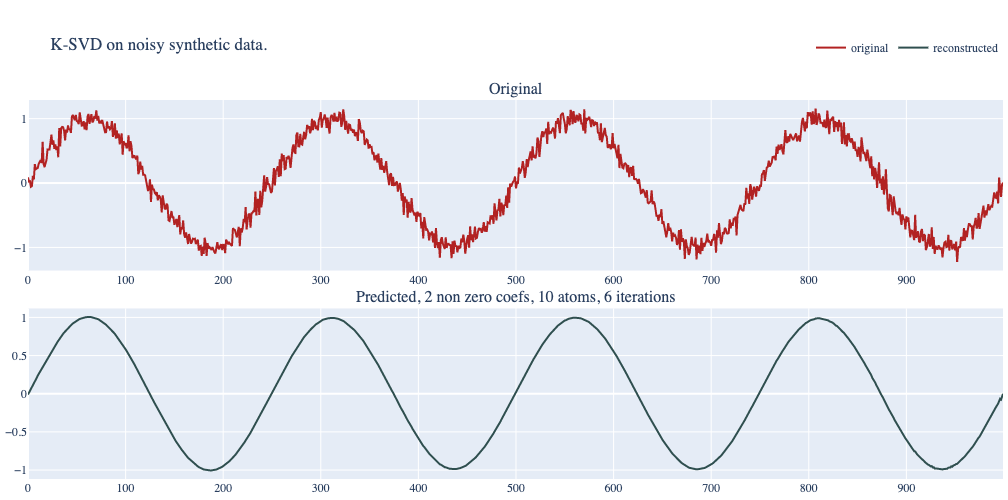

In [14]:
fig = plot_original_pred(save_path="images/noisy_sinus.pdf", y_pred=pred, y_true=measure, n_coefs=2, K=10, n_iter=ksvd.n_iter, title="K-SVD on noisy synthetic data.")

### Convergence study

We analyse the difference between the reconstructed signal and the original signal and we analyse the norm of two successive dictionnaries of the iterative algorithm.



In [15]:
n_coefs = 2
K = 10
max_iter = 20
ksvd = KSVD(n_nonzero_coefs=n_coefs, K=K, max_iter=max_iter, tol=-np.inf)

D, Z = ksvd.fit_1d_signal(measure, 200)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.22it/s]


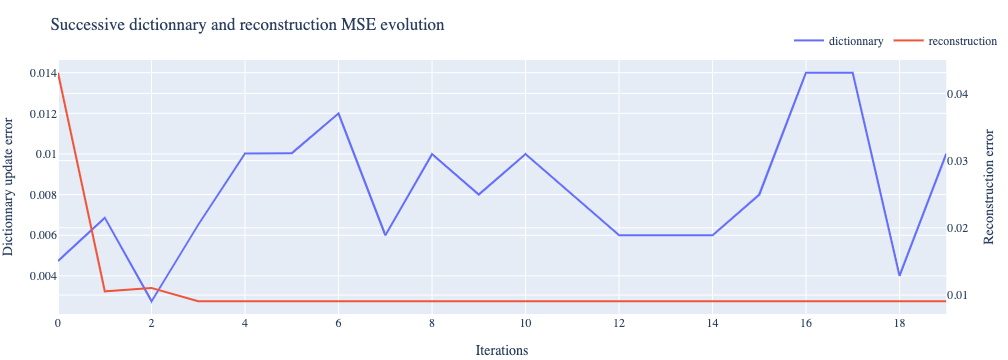

In [16]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
x_plot = np.arange(max_iter)
# Add traces
fig.add_trace(
    go.Scatter(x=x_plot, mode="lines", y=ksvd.dict_errors, name="dictionnary"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=x_plot, mode="lines", y=ksvd.reconstruction_errors, name="reconstruction"),
    secondary_y=True,
)


# Set x-axis title
fig.update_xaxes(title_text="Iterations")

# Set y-axes titles
fig.update_yaxes(title_text="Dictionnary update error", secondary_y=False)
fig.update_yaxes(title_text="Reconstruction error", secondary_y=True)
fig.update_layout(
    margin={"t": 60, "b": 5, "r": 5, "l": 5},
    showlegend=True,
    font_family="Serif",
    title_text="Successive dictionnary and reconstruction MSE evolution",
    width=600,
    height=300,
    legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
    )
    )
fig.show()
pio.write_image(fig, "images/dict_reconstruction_mse.pdf")

## Denoising study

### Gaussian Noise with synthetic data

In [17]:
n_samples = 2048
tt = np.linspace(0, 1, n_samples)
signal = np.sqrt(tt * (1 - tt)) * np.sin((2.1 * np.pi) / (tt + .05))
signal /= signal.std()
rng = np.random.RandomState(0)
noise = 0.3 * rng.randn(*signal.shape)
snr = 20. * np.log10(signal.std() / noise.std())
measure = signal + noise

In [18]:
n_coefs = 5
K = 100
ksvd = KSVD(n_nonzero_coefs=n_coefs, K=K, max_iter=20, tol=1e-4)

D, Z = ksvd.fit_1d_signal(measure, 400)
pred = ksvd.predict_1d_signal(measure)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.54it/s]


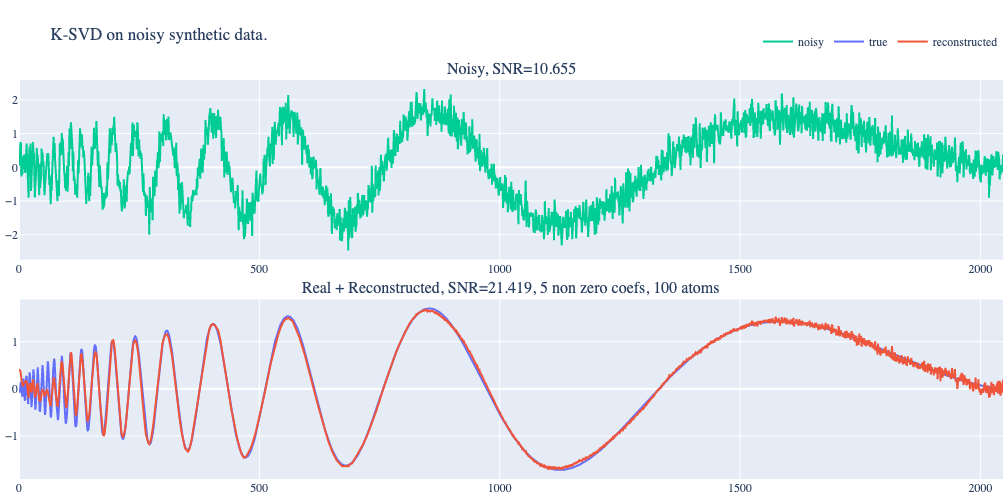

In [19]:
fig = plot_real_noisy_pred(save_path="images/denoising_synthetic.pdf", y_true=signal, y_noisy=measure, y_pred=pred, n_coefs=n_coefs, K=K, title="K-SVD on noisy synthetic data.", vertical_spacing=.1, width=700, height=500)

In [20]:
def build_predict(X, n_coefs, K, max_iter=3, N=400, jump=1, tol=1e-4, parellel=True):
    ksvd = KSVD(n_nonzero_coefs=n_coefs, K=K, max_iter=max_iter, tol=tol, parallel=Parallel)
    return ksvd.fit_predict_1d_signal(X, N, jump=jump)

def build_predict_snr(X_noisy, X_true, **kwargs):
    X_pred = build_predict(X_noisy, **kwargs)
    return SNR(X_true, X_pred)

In [21]:
n_coefs = np.arange(1, 100, 3)
K = 100
N = 400

#n_coefs_snr = Parallel(n_jobs=-1)(delayed(build_predict_snr)(measure, signal, N=N, n_coefs=n, K=K, max_iter=3) for n in n_coefs) 

In [22]:
#plot_line(save_path="images/snr_n_coefs.pdf", x=n_coefs, y=n_coefs_snr, title=f'SNR vs number of non zero coefficients with {K} atoms', x_axes_title='non zero coefficients', y_axes_title='SNR', name='SNR')

In [23]:
n_coefs = 5
K = np.arange(10, 1000, 10)
N = 400

#K_snr = Parallel(n_jobs=-1)(delayed(build_predict_snr)(measure, signal, N=N, n_coefs=n_coefs, K=k, max_iter=3) for k in K) 

In [24]:
#plot_line(save_path="images/snr_n_atoms.pdf", x=K, y=K_snr, title=f'SNR vs number of atoms with {n_coefs} coefficients', x_axes_title='number of atoms', y_axes_title='SNR', name='SNR')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.89it/s]


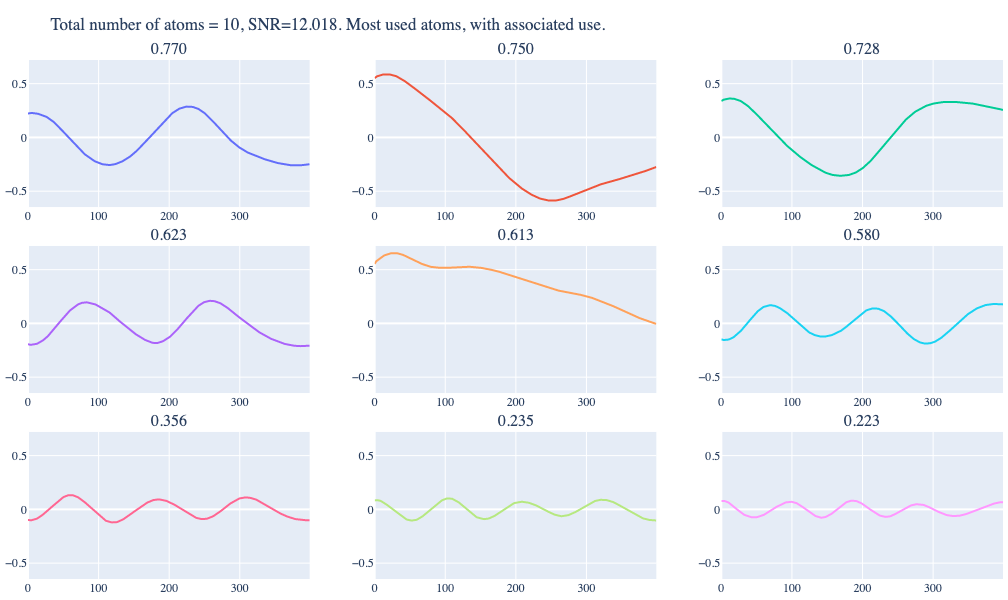

In [25]:
n_coefs = 5
K = 10
ksvd = KSVD(n_nonzero_coefs=n_coefs, K=K, max_iter=3, tol=1e-4)

D, Z = ksvd.fit_1d_signal(measure, 400)
pred = ksvd.predict_1d_signal(measure)
plot_atoms(save_path=f"images/synthetic_denoising_atoms_{K}.pdf", D=D, Z=Z, n_rows=3, vertical_spacing=.075, title=f'Total number of atoms = {K}, SNR={SNR(signal, pred):.3f}. Most used atoms, with associated use.')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s]


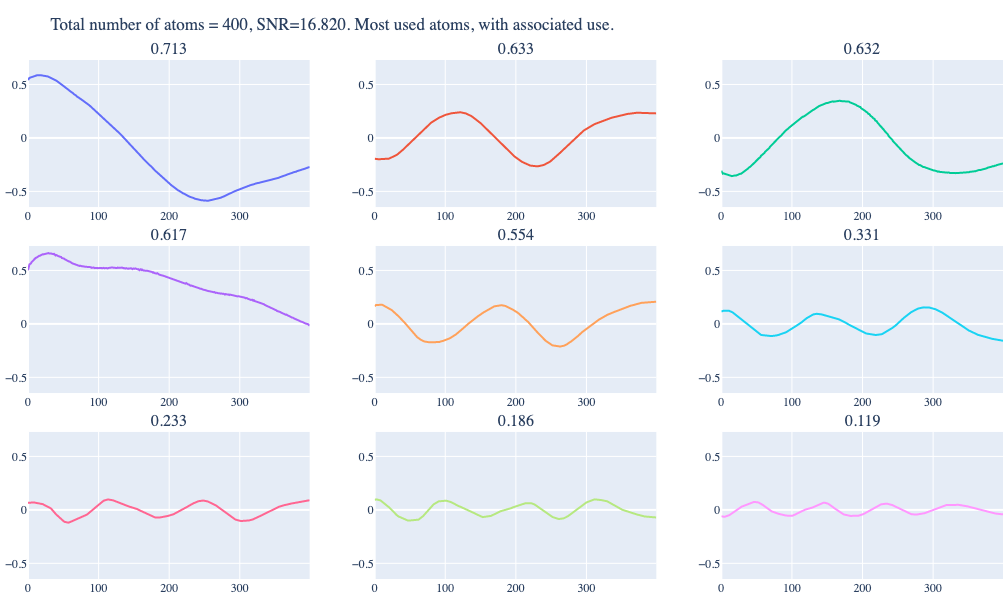

In [26]:
n_coefs = 5
K = 400
ksvd = KSVD(n_nonzero_coefs=n_coefs, K=K, max_iter=3, tol=1e-4)

D, Z = ksvd.fit_1d_signal(measure, 400)
pred = ksvd.predict_1d_signal(measure)
plot_atoms(save_path=f"images/synthetic_denoising_atoms_{K}.pdf", D=D, Z=Z, n_rows=3, vertical_spacing=.075, title=f'Total number of atoms = {K}, SNR={SNR(signal, pred):.3f}. Most used atoms, with associated use.')

### Salt and pepper noise (Outliers noise)

In [27]:
PATH = "data/audio_and_txt_files"

def read_respiratory_data():
    signals = []
    for file in tqdm(os.listdir(PATH)):
        if "wav" in file and "Al" in file:
            a = read_wav(os.path.join(PATH, file))
            sound_array = np.array(a[1], dtype=float)[::50]
            signals.append((sound_array - np.mean(sound_array))/np.std(sound_array))
    return signals

In [28]:
resp_dataset = read_respiratory_data()
training_data = resp_dataset[:150]
test_data = resp_dataset[150:]
print(resp_dataset[0].shape)
print(len(resp_dataset))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1840/1840 [00:01<00:00, 1470.53it/s]

(17640,)
162


In [29]:
JUMP = 600
signal_arrays = []

for signal in training_data:
    traj_matrix = get_trajectory_matrix(signal, JUMP, jump=JUMP)
    signal_arrays.append(traj_matrix)


In [30]:
all_signals_array = np.concatenate(signal_arrays, axis=1)
all_signals_array.shape

(600, 4028)

In [31]:
np.random.shuffle(np.transpose(all_signals_array))
all_signals_array.shape

(600, 4028)

In [32]:
learning_arrays = all_signals_array[:,:15000]
learning_arrays.shape

(600, 4028)

In [33]:
ksvd = KSVD(n_nonzero_coefs=20, K=300, max_iter=50)
D, Z = ksvd.fit(learning_arrays)

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 45/50 [06:27<00:43,  8.61s/it]


In [34]:
X = get_trajectory_matrix(test_data[0], JUMP, jump=JUMP)
X.shape

(600, 29)

In [35]:
reconstructed_X = ksvd.predict_1d_signal(test_data[0], N=JUMP, jump=JUMP)


In [36]:
## Graphique A refaire

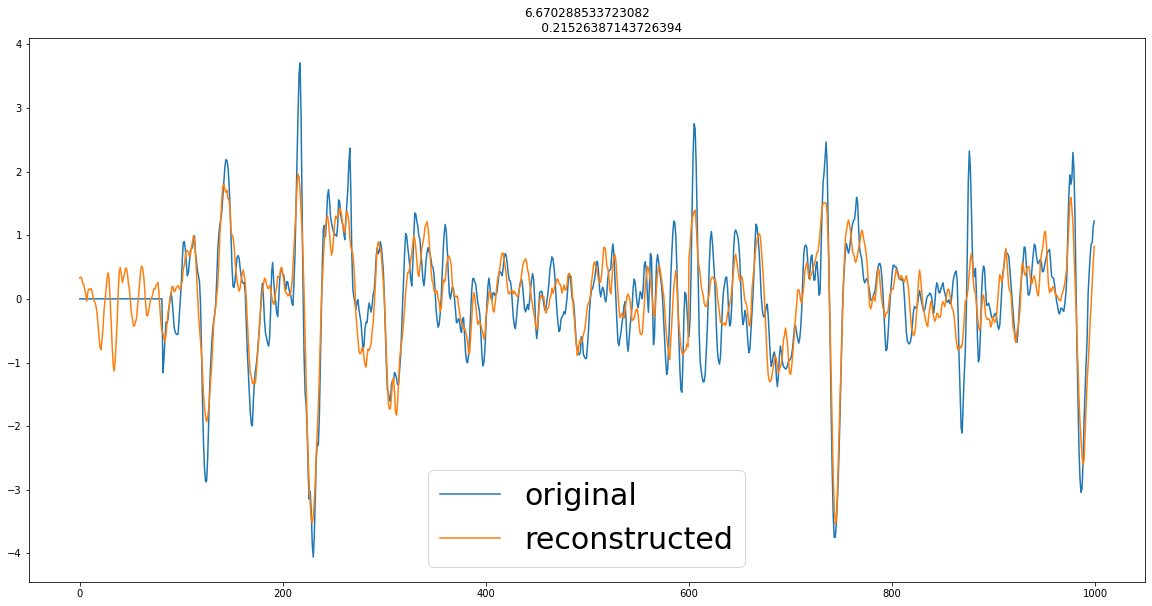

In [37]:
plt.figure(figsize=(20,10))
plt.plot(test_data[0][:1000], label="original")
#plt.figure(figsize=(20,10))
plt.plot(reconstructed_X[:1000], label="reconstructed")
plt.title(f"{SNR(test_data[0][:1000], reconstructed_X[:1000])}\n \
            {MSE(test_data[0][:1000], reconstructed_X[:1000])}")

plt.legend(prop={'size': 30})
plt.show()

In [47]:
signal = test_data[0].copy()

In [48]:
PROPORTION_BAD_POINTS = 0.01
MAX_SIGNAL = 3 * np.abs(np.max(signal))
MIN_SIGNAL = - 3 * np.abs(np.max(signal))

new_signal = []

for i, elem in enumerate(signal):
    p = np.random.uniform()
    if p >= PROPORTION_BAD_POINTS:
        new_signal.append(elem)
    elif 0 <= p < PROPORTION_BAD_POINTS/2:
        new_signal.append(MIN_SIGNAL)
    else:
        new_signal.append(MAX_SIGNAL)



In [49]:
example = np.array(new_signal)

reconstructed_X = ksvd.predict_1d_signal(example, N=JUMP, jump=JUMP)

In [50]:
## Graphe à refaire

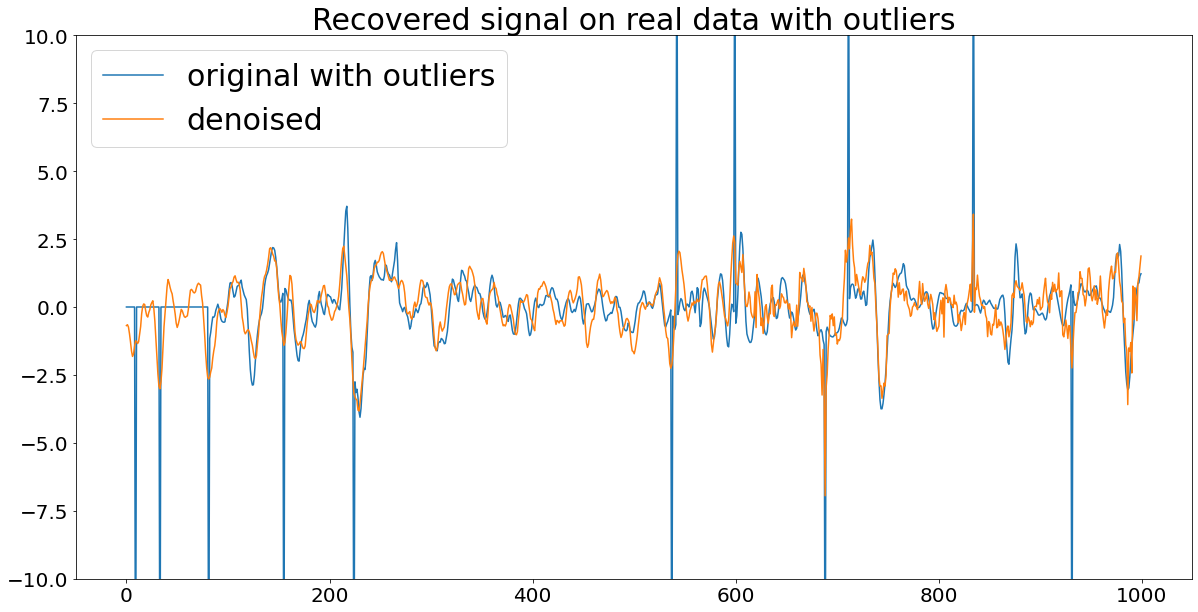

In [51]:
plt.figure(figsize=(20,10))
plt.plot(example[:1000], label="original with outliers")
#plt.figure(figsize=(20,10))
plt.plot(reconstructed_X[:1000], label="denoised")
plt.ylim([-10, 10])
#plt.title(f"{SNR(test_data[0], example)}, {SNR(test_data[0], reconstructed_X)}\n \
#            {MSE(test_data[0], example)}, {MSE(test_data[0], reconstructed_X)}")
plt.title("Recovered signal on real data with outliers", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 30})
plt.show()

In [54]:
orig_snr = []
recons_snr = []
orig_mse = []
recons_mse = []
orig_orig_snr = []
orig_orig_mse = []

for test_signal in tqdm(test_data):
    signal = test_signal.copy()
    PROPORTION_BAD_POINTS = 0.01
    MAX_SIGNAL = 3 * np.abs(np.max(signal))
    MIN_SIGNAL = - 3 * np.abs(np.max(signal))
    
    reconstructed_X = ksvd.predict_1d_signal(signal, N=JUMP, jump=JUMP)
    
    orig_orig_snr.append(SNR(test_signal, reconstructed_X))
    orig_orig_mse.append(MSE(test_signal, reconstructed_X))
    
    new_signal = []

    for i, elem in enumerate(signal):
        p = np.random.uniform()
        if p >= PROPORTION_BAD_POINTS:
            new_signal.append(elem)
        elif 0 <= p < PROPORTION_BAD_POINTS/2:
            new_signal.append(MIN_SIGNAL)
        else:
            new_signal.append(MAX_SIGNAL)

    example = np.array(new_signal)

    reconstructed_X_2 = ksvd.predict_1d_signal(example, N=JUMP, jump=JUMP)

    orig_snr.append(SNR(test_signal, example))
    recons_snr.append(SNR(test_signal, reconstructed_X_2))
    orig_mse.append(MSE(test_signal, example))
    recons_mse.append(MSE(test_signal, reconstructed_X_2))
    
print("orig_orig_snr", np.mean(orig_orig_snr))
print("orig_orig_mse", np.mean(orig_orig_mse))
print("orig_snr", np.mean(orig_snr))
print("recons_snr", np.mean(recons_snr))
print("orig_mse", np.mean(orig_mse))
print("recons_mse", np.mean(recons_mse))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:22<00:00,  1.90s/it]

orig_orig_snr 6.443914322068035
orig_orig_mse 0.2590884514629367
orig_snr -1.6748060519654189
recons_snr 3.64923465622636
orig_mse 2.072162120836558
recons_mse 0.4835085754868942


## Classification

In [55]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import homogeneity_score, completeness_score, normalized_mutual_info_score, adjusted_rand_score, classification_report
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [56]:
star_path = "data/StarLightCurves/StarLightCurves_TRAIN.ts"

In [57]:
%%capture 
import sktime
from sktime.datasets import load_from_tsfile_to_dataframe
from sklearn.cluster import KMeans

ModuleNotFoundError: No module named 'sktime'

In [46]:
df_stars, labels = load_from_tsfile_to_dataframe(star_path)
labels = labels.astype(int)

NameError: name 'load_from_tsfile_to_dataframe' is not defined

In [ ]:
stars_list = []
for i in range(df_stars.shape[0]):
    stars_list.append(df_stars.iloc[i][0].to_numpy())

stars_array = np.array(stars_list)

In [ ]:
X = stars_array.T

In [ ]:
mask_1 = labels == 1
mask_2 = labels == 2
mask_3 = labels == 3

stars_1 = stars_array[mask_1]
stars_2 = stars_array[mask_2]
stars_3 = stars_array[mask_3]

stars_1.shape, stars_2.shape, stars_3.shape

In [ ]:
cmap = px.colors.qualitative.Plotly

In [ ]:
fig = plot_line(y=stars_1[2], color=cmap[0], name='1', title="One example of each kind of star.", return_fig=True)
fig.add_trace(plot_line(y=stars_2[6], color=cmap[1], name='2', return_fig=True).data[0])
fig.add_trace(plot_line(y=stars_3[2], color=cmap[2], name='3', return_fig=True).data[0])
fig.update_layout(width=400)
fig.show()
pio.write_image(fig, "images/stars_signal.pdf")

In [ ]:
fft_1 = np.fft.fftshift(np.abs(np.fft.fft(stars_1, axis=1)))
fft_2 = np.fft.fftshift(np.abs(np.fft.fft(stars_2, axis=1)))
fft_3 = np.fft.fftshift(np.abs(np.fft.fft(stars_3, axis=1)))


In [ ]:
fig = plot_line(y=np.log(.1 + fft_1.mean(axis=0)), color=cmap[0], name='1', title="Mean FFT module of each class of stars (log scale).", return_fig=True)
fig.add_trace(plot_line(y=np.log(.1 + fft_2.mean(axis=0)), color=cmap[1], name='2', return_fig=True).data[0])
fig.add_trace(plot_line(y=np.log(.1 + fft_3.mean(axis=0)), color=cmap[2], name='3', return_fig=True).data[0])
fig.update_layout(width=400)
fig.show()
pio.write_image(fig, "images/fft_stars_signal.pdf")

In [ ]:
def build_predict(X, n_coefs, K, max_iter=3, tol=1e-4, parellel=True):
    ksvd = KSVD(n_nonzero_coefs=n_coefs, K=K, max_iter=max_iter, tol=tol, parallel=Parallel)
    return ksvd.fit(X)

def build_predict_clustering(X, **kwargs):
    kmeans = KMeans(n_clusters=3)
    D, Z = build_predict(X, **kwargs)
    pred_labels = kmeans.fit_predict(Z.T)
    homogeneity = homogeneity_score(labels, pred_labels)
    completeness = completeness_score(labels, pred_labels)
    return (homogeneity, completeness)

In [ ]:
build_predict_clustering(X, K=3, n_coefs=1)

In [ ]:
n_coefs = 5
K = np.arange(5, 50, 1)

clustering_scores = Parallel(n_jobs=-1)(delayed(build_predict_clustering)(X, n_coefs=n_coefs, K=k, max_iter=6) for k in K)

In [ ]:
kmeans = KMeans(n_clusters=3)
pred_labels = kmeans.fit_predict(X.T)
baseline_homogeneity = homogeneity_score(labels_true=labels, labels_pred=pred_labels)
baseline_completeness = completeness_score(labels_true=labels, labels_pred=pred_labels)

In [ ]:
homogeneity = [c[0] for c in clustering_scores]
completeness = [c[1] for c in clustering_scores]

fig = plot_line(x=K, y=homogeneity, name="homogeneity", color="firebrick", title="5 coefficients, clustering evolution with K.", return_fig=True)
fig.add_trace(plot_line(x=K, y=completeness, name="completeness", color="darkslategray", return_fig=True).data[0])
fig.add_shape(type="line", x0=5, x1=49, y0=baseline_homogeneity, y1=baseline_homogeneity, line=dict(color="lightslategray", dash="dot"))
fig.add_shape(type="line", x0=5, x1=49, y0=baseline_completeness, y1=baseline_completeness, line=dict(color="lightslategray", dash="dot"))
fig.add_trace(go.Scatter(
    x=[42, 42],
    y=[.64, .572],
    text=["baseline homogeneity",
          "baseline completeness",],
    mode="text",
    showlegend=False
))
fig.update_layout(width=400,)
fig.update_xaxes(title="number of atoms, K")
fig.show()
pio.write_image(fig, "images/n_atoms_clustering.pdf")

In [ ]:
n_coefs = 5
K = 24
ksvd = KSVD(n_nonzero_coefs=n_coefs, K=K, max_iter=6, tol=1e-6)

D, Z = ksvd.fit(X)
X_pred = D @ Z

print("MSE:", MSE(X, X_pred))

In [ ]:
nnz_coefs = (Z != 0)
nnz_coefs_1 = np.abs(Z[:, mask_1])
nnz_coefs_2 = np.abs(Z[:, mask_2])
nnz_coefs_3 = np.abs(Z[:, mask_3])

sum_1 = nnz_coefs_1.sum(axis=1)
sum_2 = nnz_coefs_2.sum(axis=1)
sum_3 = nnz_coefs_3.sum(axis=1)
x_plot = np.arange(24)
fig = go.Figure(data=[
    go.Bar(name="1", x=x_plot, y=sum_1),
    go.Bar(name="2", x=x_plot, y=sum_2),
    go.Bar(name="3", x=x_plot, y=sum_3)
    ]
)
fig.update_layout(barmode="stack")
fig.update_layout(
    margin={"t": 60, "b": 5, "r": 5, "l": 5},
    showlegend=True,
    font_family="Serif",
    title_text="Class usage of the 24 atoms, 5 coefficients.",
    width=400,
    height=300,
    legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
    )
    )
fig.show()
pio.write_image(fig, "images/class_repartition.pdf")

In [ ]:
mask_1 = labels == 1
mask_2 = labels == 2
mask_3 = labels == 3

pred_1 = X_pred.T[mask_1]
pred_2 = X_pred.T[mask_2]
pred_3 = X_pred.T[mask_3]

list_pred = [pred_1, pred_2, pred_3]
list_true = [stars_1, stars_2, stars_3]

In [ ]:
fig = plot_several_reconstructed(X_pred=X_pred, X_true=X, n_rows=3)

In [ ]:
width = 600
height = 150
n_rows = 2
title = "Reconstruction, 24 atoms, 5 coefficients."
subplot_titles = [f"class {i % 3 + 1}" for i in range(3 * n_rows)]
fig = make_subplots(
    rows=n_rows,
    cols=3,
    subplot_titles=subplot_titles,
    vertical_spacing=.16,
    horizontal_spacing=.05
)
x = np.arange(X_pred.shape[0])
n_plot = 0
for i in range(1, n_rows + 1):
    for j in range(1, 4):
        showlegend = (i == 1) and (j == 1)
        trace_true = go.Scatter(
            x=x, y=list_true[j-1][n_plot], line=dict(color="lightslategray"), name="original", showlegend=showlegend, legendgroup="true"
        )
        trace_pred = go.Scatter(
            x=x, y=list_pred[j-1][n_plot], line=dict(color="firebrick"), name="reconstructed", showlegend=showlegend, legendgroup="reconstructed"
        )
        fig.add_traces([trace_true, trace_pred,], rows=[i, i], cols=[j, j])
        n_plot += 1
        if n_plot >= 3 * n_rows:
            break
fig.update_layout(
    margin={"t": 60, "b": 5, "r": 5, "l": 5},
    showlegend=True,
    font_family="Serif",
    title=title,
    width=width,
    height=n_rows * height,
    legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.06,
    xanchor="right",
    x=1
    )
)
fig.show()
pio.write_image(fig, "images/stars-small-reconstruction.pdf")

In [ ]:
for i in range(3):
    print(f"MSE class {i+1}: {MSE(list_pred[i], list_true[i]):.4f}")

In [ ]:
most_used_1 = nnz_coefs_1.argsort()[::-1]
most_used_2 = nnz_coefs_2.argsort()[::-1]
most_used_3 = nnz_coefs_3.argsort()[::-1]
list_most_used = [most_used_1, most_used_2, most_used_3]
list_masks = [mask_1, mask_2, mask_3]
width = 600
height = 150
n_rows = 2
title = "Reconstruction, 24 atoms, 5 coefficients."
subplot_titles = [f"class {i % 3 + 1}" for i in range(3 * n_rows)]
fig = make_subplots(
    rows=n_rows,
    cols=3,
    subplot_titles=subplot_titles,
    vertical_spacing=.16,
    horizontal_spacing=.05
)

x = np.arange(D.shape[0])
n_plot = 0
for i in range(1, n_rows + 1):
    for j in range(1, 4):
        trace = go.Scatter(x=x, y=D[:, mask][:, ])
        fig.add_trace(trace, row=i, col=j)
        n_plot += 1
        if n_plot >= 3 * n_rows:
            break
fig.update_layout(
    margin={"t": 60, "b": 5, "r": 5, "l": 5},
    showlegend=False,
    font_family="Serif",
    title=title,
    width=width,
    height=n_rows * height,
)
if d_max is not None:
    fig.update_yaxes(range=[d_min - .1 * np.abs(d_min), d_max + .1 * np.abs(d_max)])
fig.show()
return fig


In [ ]:
fig = plot_line(y=pred_1[2], color=cmap[0], name='1', title="One example of each kind of star.", return_fig=True)
fig.add_trace(plot_line(y=pred_2[6], color=cmap[1], name='2', return_fig=True).data[0])
fig.add_trace(plot_line(y=pred_3[2], color=cmap[2], name='3', return_fig=True).data[0])
fig.update_layout(width=400)
fig.show()
# pio.write_image(fig, "images/stars_signal.pdf")


In [ ]:
kmeans = KMeans(n_clusters=3)
pred_labels = kmeans.fit_predict(Z.T)
clustering_evaluation(pred_labels=pred_labels, true_labels=labels)

In [ ]:
import sktime
from sktime.datasets import load_from_tsfile_to_dataframe